In [179]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt

# Carga de datos

En primer lugar, cargamos los datos proporcionados y visualizamos las variables de las que disponemos.

In [181]:
df = pd.read_excel('../data/Handball Woman European Data Set.xlsx', index_col=0)

In [182]:
df.tail(6)

,Phase,Match,Team,No,Name,Goals,Shots,%,7m%,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,YC,RC,2M,2+2,AS,R7,ST,BS,P7,TO,Time,scoring,MVP
1494,FINAL,FRA-NOR,NOR,13,DALE Kari,1,1,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,60.000000,0.2,0
1495,FINAL,FRA-NOR,NOR,16,LUNDE Katrine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.283333,0.0,0
1496,FINAL,FRA-NOR,NOR,20,JACOBSEN Marit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0
1497,FINAL,FRA-NOR,NOR,23,HERREM Camilla,3,4,75,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,37.000000,3.1,0
1498,FINAL,FRA-NOR,NOR,24,SOLBERG-ISAKSEN Sanna Charlotte,1,2,50,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.000000,0.3,0
1499,FINAL,FRA-NOR,NOR,25,BREISTOL Kristine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0


In [183]:
df.dtypes

Phase          object
Match          object
Team           object
No              int64
Name           object
Goals           int64
Shots           int64
%               int64
7m%             int64
7mPGoals        int64
7mPMissed       int64
6mCGoals        int64
6mCMissed       int64
WingGoals       int64
WingMissed      int64
BTGoals         int64
BTMissed        int64
FBGoals         int64
FBMissed        int64
FTOGoals        int64
FTOMissed       int64
9mGoals         int64
9mMissed        int64
YC              int64
RC              int64
2M              int64
2+2             int64
AS              int64
R7              int64
ST              int64
BS              int64
P7              int64
TO              int64
Time          float64
scoring       float64
MVP             int64
dtype: object

# Clustering inicial

Realizamos una aproximación inicial utilizando los datos agregados con todos los goles y lanzamientos. Agrupamos los datos de esas dos variables por el nombre de la jugadora.

In [184]:
simplified_df = df[['Name', 'Goals', 'Shots']]
# Agrupamos por nombre y sumamos las estadísticas de cada jugadora
players_df = simplified_df.groupby('Name').sum().reset_index()
players_df

,Name,Goals,Shots
0,ABBINGH Lois,35,67
1,ABINA Ana,0,0
2,ABINA Ema,0,1
3,AGBABA Jelena,2,2
4,ARDERIUS Silvia,3,6
...,...,...,...
265,ZYCH Aleksandra,4,12
266,van KREIJ Harma,1,1
267,van WETERING Bo,18,35
268,van der HEIJDEN Laura,21,40


Visualizamos los datos aprovechando que tenemos dos variables

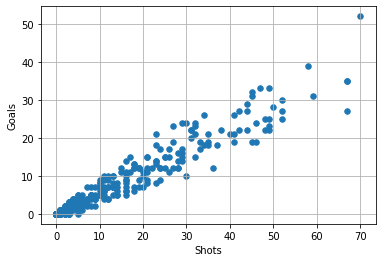

In [185]:
X = players_df[['Shots', 'Goals']]

plt.scatter(X['Shots'], X['Goals'], s=30)
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.grid()
plt.show()

Aplicamos Expectation-Maximization (EM). Para saber cuáles son los parámetros óptimos, buscamos cuál es el BIC menor para distintas configuraciones.

In [202]:
from sklearn.mixture import GaussianMixture

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 12)

BIC = []
lowest_bic = np.infty
best_cv = 'full'
best_k = -1

for cv_type in cv_types:
    for k in n_components_range:
        EM = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        EM.fit(X)
        
        BIC.append(EM.bic(X))
        
        if BIC[-1] < lowest_bic:
            lowest_bic = BIC[-1]
            best_cv = cv_type
            best_k = k
            
print("Mejor valor K:", best_k)
print("Mejor tipo de Covarianza:", best_cv)

Mejor valor K: 7
Mejor tipo de Covarianza: spherical


Aunque en el fragmento anterior ya se muestra que la parametrización óptima según el BIC es con 7 componentes y covarianza esférica, mostramos en un gráfico de barras los BIC obtenidos para ver los resultados según las distintas configuraciones.

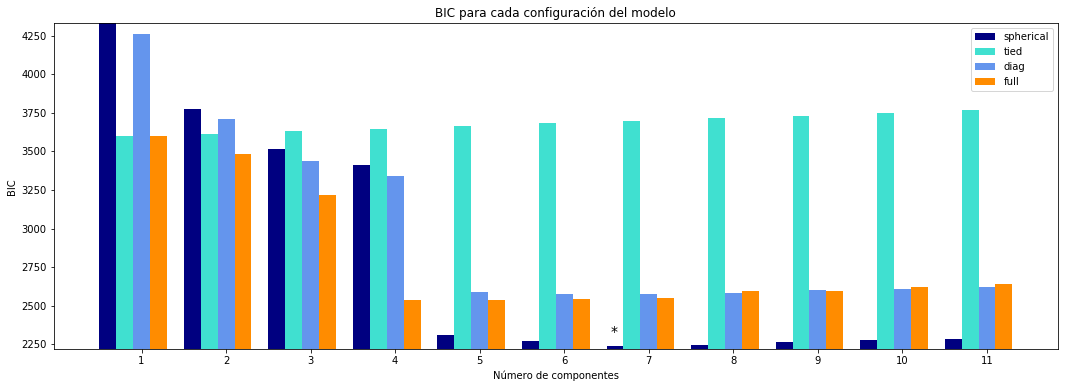

In [203]:
import itertools
import matplotlib.pyplot as plt

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

plt.figure(figsize=(18, 6))
bars = []
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos,
                        BIC[i * len(n_components_range):(i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(BIC) * 1.01 - .01 * max(BIC), max(BIC)])

plt.title('BIC para cada configuración del modelo')
plt.xlabel('Número de componentes')
plt.ylabel('BIC')
plt.legend([b[0] for b in bars], cv_types)

xpos = np.mod(np.argmin(BIC), len(n_components_range)) + .55 + .2 * np.floor(np.argmin(BIC) / len(n_components_range))
plt.text(xpos, min(BIC) * 0.97 + .03 * max(BIC), '*', fontsize=14)

plt.show()

Debido a la forma de los datos siguiendo una línea, no hay mucha variación a partir de 6 componentes (simplemente agrupa haciendo "cortes" en la línea.

En cualquier caso, aplicamos el EM con 7 componentes y covarianza esférica para mostrar el resultado final.

In [204]:
print(f"Expectation-Maximization with K={best_k} and covariance '{best_cv}'")
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
EM.fit(X)
labels =  EM.predict(X)

Expectation-Maximization with K=7 and covariance 'spherical'


Definimos una función de utilidad para pintar el resultado del EM con los círculos representando las gausianas. Se usará también más adelante.

In [244]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

def plot_EM(model, X, grid=False, labels=None, out=None):
    if labels is None:
        # Calculamos las agrupaciones si no estaban hechas
        labels = model.fit(X).predict(X)
    
    ax = plt.gca()
    clusters = np.unique(labels)
    
    norm = Normalize(vmin=0, vmax=len(clusters)-1)
    cmap = get_cmap('viridis')
    
    # Pintamos los puntos de cada clúster
    # Lo hacemos separado para poder mostrar la leyenda con el número de clúster
    for cluster_index in clusters:
        ax.scatter(
            X.loc[labels == cluster_index].iloc[:,0],
            X.loc[labels == cluster_index].iloc[:,1],
            c=[cmap(norm(cluster_index))],
            label=cluster_index,
            s=40,
            zorder=2)
    #ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    ax.legend()
    
    # Calculamos la forma de las elipses de las gausianas según el tipo de covarianza que se haya usado y las pintamos
    w_factor = 0.2 / model.weights_.max()
    for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
        if covar.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covar)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        elif covar.shape == (2,):
            angle = 0
            width, height = 2 * np.sqrt(covar)
        else:
            angle = 0
            width = height = 2 * np.sqrt(covar)
    
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(pos, nsig * width, nsig * height, angle, alpha=w * w_factor))
    
    if grid:
        plt.grid()
        
    if out is not None:
        plt.savefig(out)
    
    plt.show()

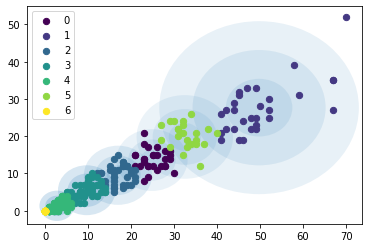

In [248]:
#plt.scatter(X['Shots'], X['Goals'], c=labels, s=30)
#plt.xlabel('Shots')
#plt.ylabel('Goals')
#plt.grid()
#plt.show()

plot_EM(EM, X)
#plot_EM(EM, X, out='../figures/Hito1_analisis_exploratorio.pdf')

# Variables significativas y limpieza de datos

## Variables relevantes

Primero, vamos a analizar qué valores aparecen en cada variable. Descartamos previamente las que son indicativas, agregadas o no relevantes según la opinión del experto.

In [35]:
for column in df:
    if column in ['Phase', 'Match', 'Team', 'No', 'Name', '%', '7m%', 'YC', 'Time', 'scoring', 'MVP']:
        continue
    print(column, ':', sorted(df[column].unique()))

Goals : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Shots : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19]
7mPGoals : [0, 1, 2, 3, 4, 5, 6, 8, 9]
7mPMissed : [0, 1, 2]
6mCGoals : [0, 1, 2, 3, 4, 5, 6]
6mCMissed : [0, 1, 2, 3]
WingGoals : [0, 1, 2, 3, 4, 5, 6]
WingMissed : [0, 1, 2, 3, 4]
BTGoals : [0, 1, 2, 3, 4]
BTMissed : [0, 1, 2, 4]
FBGoals : [0, 1, 2, 3, 4, 6]
FBMissed : [0, 1, 2, 3]
FTOGoals : [0, 1]
FTOMissed : [0, 1]
9mGoals : [0, 1, 2, 3, 4, 5, 6, 7]
9mMissed : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RC : [0, 1]
2M : [0, 1, 2, 3]
2+2 : [0]
AS : [0, 1, 2, 3, 4, 5, 6, 7]
R7 : [0, 1, 2, 3, 4]
ST : [0, 1, 2, 3, 4, 5]
BS : [0, 1, 2, 3, 4, 5, 7]
P7 : [0, 1, 2, 3, 4]
TO : [0, 1, 2, 3, 4, 5, 6, 7, 8]


Podemos descartar la columna '2+2' ya que no tiene variabilidad (ninguna jugadora ha recibido esta sanción).

Nos quedamos con el resto de columnas, incluyendo el nombre (usado para agrupar posteriormente).

In [171]:
# ['Phase','Match','Team','No','Name','Goals','Shots','%','7m%','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','YC','RC','2M','2+2','AS','R7','ST','BS','P7','TO','Time','scoring','MVP']

valid_cols = ['Name','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','RC','2M','AS','R7','ST','BS','P7','TO']
valid_cols_df = df[valid_cols]

print(valid_cols_df.shape)
valid_cols_df.dtypes

(1500, 23)


Name          object
7mPGoals       int64
7mPMissed      int64
6mCGoals       int64
6mCMissed      int64
WingGoals      int64
WingMissed     int64
BTGoals        int64
BTMissed       int64
FBGoals        int64
FBMissed       int64
FTOGoals       int64
FTOMissed      int64
9mGoals        int64
9mMissed       int64
RC             int64
2M             int64
AS             int64
R7             int64
ST             int64
BS             int64
P7             int64
TO             int64
dtype: object

## Correlación entre variables

Calculamos la correlación entre las columnas restantes para evitar usar datos que puedan ser redundantes.

,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
7mPGoals,1.000000,0.351281,0.030956,0.006809,0.090887,0.086811,0.054380,0.036003,0.038648,0.005507,0.017628,0.070373,0.121645,0.194042,0.022926,0.012591,0.196836,0.049664,0.033785,-0.028960,0.023096,0.193945
7mPMissed,0.351281,1.000000,0.042575,0.079381,0.049186,0.114517,0.073540,-0.002644,-0.018820,-0.003924,-0.014587,-0.020664,0.207220,0.223470,-0.013043,-0.034917,0.182316,0.070212,0.020076,-0.031242,0.002748,0.188635
6mCGoals,0.030956,0.042575,1.000000,0.279227,-0.013642,-0.021878,0.021924,0.023615,0.038504,0.048838,0.060667,0.051068,-0.026355,-0.012635,0.035902,0.124744,0.090927,0.205067,0.081618,0.153954,0.133822,0.060188
6mCMissed,0.006809,0.079381,0.279227,1.000000,0.004404,0.017123,0.034517,0.020171,0.073635,0.007369,0.014639,0.020737,0.047607,0.022841,0.020254,0.072048,0.128457,0.122039,0.088038,0.047373,0.053356,0.098192
WingGoals,0.090887,0.049186,-0.013642,0.004404,1.000000,0.307327,0.023688,-0.005942,0.224087,0.175887,0.025256,0.055766,-0.004538,-0.028987,-0.027881,0.013472,0.044951,0.098252,0.172809,-0.041477,0.062861,0.054015
WingMissed,0.086811,0.114517,-0.021878,0.017123,0.307327,1.000000,0.061275,-0.025794,0.196582,0.086577,0.005994,-0.015540,0.003512,-0.010805,-0.006017,-0.021472,0.026991,0.064460,0.112993,-0.054909,-0.034421,0.044165
BTGoals,0.054380,0.073540,0.021924,0.034517,0.023688,0.061275,1.000000,0.294483,0.025685,-0.002774,-0.020056,0.022934,0.246932,0.211285,0.009074,0.056036,0.356221,0.113818,0.080395,0.048908,0.084301,0.290403
BTMissed,0.036003,-0.002644,0.023615,0.020171,-0.005942,-0.025794,0.294483,1.000000,-0.015173,0.028141,0.060012,0.032318,0.125560,0.186369,0.070288,0.076742,0.302543,0.097359,0.050278,0.011353,0.069431,0.200058
FBGoals,0.038648,-0.018820,0.038504,0.073635,0.224087,0.196582,0.025685,-0.015173,1.000000,0.236117,0.023899,0.065595,-0.020298,-0.062668,0.006344,0.006316,0.051340,0.041724,0.253604,0.012597,0.021528,0.050431
FBMissed,0.005507,-0.003924,0.048838,0.007369,0.175887,0.086577,-0.002774,0.028141,0.236117,1.000000,-0.015411,0.116926,0.003984,-0.022013,-0.013780,-0.014287,0.046913,0.042619,0.183434,-0.022343,0.017051,0.006867


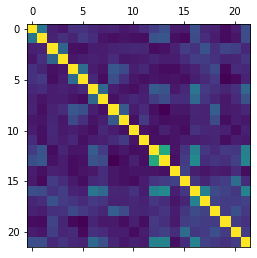

In [172]:
corr = valid_cols_df.corr(method='pearson')
plt.matshow(corr)
corr

In [178]:
def get_redundant_pairs(column_names):
    drop_pairs = set()
    for i in range(len(column_names)):
        for j in range(i+1):
            drop_pairs.add((column_names[i], column_names[j]))
    return drop_pairs

# Obtenemos el valor absoluto (rango 0-1) y quitamos los pares redundantes (uno de los triángulos a un lado de la diagonal)
corr_df = corr.abs().unstack()
corr_df = corr_df.drop(labels=get_redundant_pairs(valid_cols[1:])).sort_values()

# Mostramos aquellas que tengan una correlación superior a 0.4
corr_df[corr_df > 0.4]

9mGoals   AS          0.402062
AS        R7          0.404984
9mMissed  TO          0.411908
AS        TO          0.414223
9mMissed  AS          0.440163
9mGoals   9mMissed    0.583344
dtype: float64

En este caso no hay mucha relación entre las columnas seleccionadas (más allá de la relación vista anteriormente entre lanzamientos fallidos y goles), así que no descartamos ninguna columna más.

## Procesado de datos

Agrupamos los datos por el nombre de la jugadora, agregando todos sus datos. En este caso, lo que más sentido es utilizar la suma para obtener sus estadísticas globales en todo el Europeo.

In [250]:
players_df = valid_cols_df.groupby('Name').sum().reset_index()
players_df

,Name,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
0,ABBINGH Lois,15,6,1,1,3,2,0,0,1,1,0,0,15,22,0,4,24,0,1,2,2,21
1,ABINA Ana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ABINA Ema,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,AGBABA Jelena,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ARDERIUS Silvia,0,0,1,1,2,0,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,ZYCH Aleksandra,0,0,0,0,0,2,1,0,0,0,0,0,3,6,0,2,2,0,1,3,1,5
266,van KREIJ Harma,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
267,van WETERING Bo,0,0,0,0,12,15,0,0,6,2,0,0,0,0,0,0,2,1,7,0,1,3
268,van der HEIJDEN Laura,0,0,0,0,5,1,7,4,0,0,0,0,9,14,0,1,11,5,1,0,2,10


# Outliers

Utilizamos el método Jackknife para detectar y eliminar outliers. Para ello, calculamos el la suma de los cuadrados de las distancias de cada punto a su clúster, quitando un elemento en cada iteración. De esta manera podemos ver qué valores afectan más al SSE.

In [251]:
from sklearn.cluster import KMeans

K = 5
values_df = players_df.drop('Name', 1)
SSE = []

N = len(players_df)
for i in range(N):
    X = values_df.drop(i)
    
    km = KMeans(K, 'random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    distances = km.fit_transform(X) # Distancias de cada punto a cada clúster
    distances = np.min(distances, axis=1) # Distancias de cada punto a su clúster (el más cercano, mínima distancia)
    
    SSE.append((distances**2).sum())

Outliers found at: [157, 162, 166, 176]


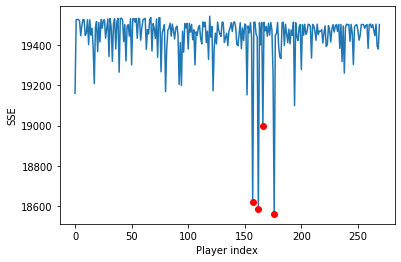

,Name,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
157,MICIJEVIC Camila,0,0,3,1,2,2,2,0,0,0,0,0,28,29,0,4,24,1,5,13,7,22
162,MORK Nora,29,6,2,0,8,6,6,2,1,0,0,0,6,4,0,0,25,8,4,0,1,11
166,NEAGU Cristina,8,4,2,1,1,1,0,2,1,2,0,0,15,30,0,0,29,1,0,0,0,14
176,OFTEDAL Stine,0,0,1,3,1,3,18,9,3,2,0,0,8,11,0,1,41,5,0,0,1,19


In [252]:
# Definimos un umbral y cortamos para ver qué valores quedan por debajo y por tanto son atípicos
sigma = np.std(SSE)
mu = np.mean(SSE)
umbral = 3
outliers = []
for i in range(N):
    if abs(SSE[i] - mu) > umbral * sigma:
        outliers.append(i)

print('Outliers found at:', outliers)

plt.plot(SSE)
for index in outliers:
    plt.plot(index, SSE[index], marker='o', color='red')
plt.xlabel('Player index')
plt.ylabel('SSE')
plt.show()

# Mostramos los valores del dataset que se corresponden a los outliers
players_df.iloc[outliers]

In [47]:
# Eliminamos los outliers de la tarjeta de datos
players_df = players_df.drop(outliers).reset_index(drop=True)
players_df

,Name,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
0,ABBINGH Lois,15,6,1,1,3,2,0,0,1,1,0,0,15,22,0,4,24,0,1,2,2,21
1,ABINA Ana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ABINA Ema,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,AGBABA Jelena,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ARDERIUS Silvia,0,0,1,1,2,0,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,ZYCH Aleksandra,0,0,0,0,0,2,1,0,0,0,0,0,3,6,0,2,2,0,1,3,1,5
262,van KREIJ Harma,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
263,van WETERING Bo,0,0,0,0,12,15,0,0,6,2,0,0,0,0,0,0,2,1,7,0,1,3
264,van der HEIJDEN Laura,0,0,0,0,5,1,7,4,0,0,0,0,9,14,0,1,11,5,1,0,2,10


# Análisis PCA

Realizamos un PCA inicial con tantas componentes como variables con el objetivo de obtener las varianzas explicadas en función del número de componentes que cojamos. Aplicamos dos tipos de escaladores para quedarnos con el que dé mejor resultado.

In [253]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler_names = ['Standard', 'MinMax']
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler()]
n_components = [2, 3]

X = players_df.drop('Name', 1)

In [254]:
for scaler_name, scaler in zip(scaler_names, scalers):
    X_scaled = scaler.fit_transform(X)
    
    estimator = PCA(n_components=22)
    X_pca = estimator.fit_transform(X_scaled)
    
    explained_variances = estimator.explained_variance_ratio_.cumsum()
    
    for n in n_components:
        print(f"[scaler={scaler_name}, n={n}] Explained variance: {100*explained_variances[n-1]:.2f}% {estimator.explained_variance_ratio_[:n]}")

[scaler=Standard, n=2] Explained variance: 39.67% [0.26576039 0.13092361]
[scaler=Standard, n=3] Explained variance: 50.00% [0.26576039 0.13092361 0.1032675 ]
[scaler=MinMax, n=2] Explained variance: 44.90% [0.31036558 0.13868297]
[scaler=MinMax, n=3] Explained variance: 55.23% [0.31036558 0.13868297 0.10327091]


## Resultados del PCA

Varianza explicada con diferentes configuraciones

| Scaler   | # Components | Explained variance | Variance per component   |
|----------|--------------|--------------------|--------------------------|
| Standard | 2            | ~40%               | [26.58%, 13.09%]         |
| Standard | 3            | ~50%               | [26.58%, 13.09%, 10.33%] |
| MinMax   | 2            | ~45%               | [31.04%, 13.87%]         |
| MinMax   | 3            | ~55%               | [31.04%, 13.87%, 10.33%] |

**Elección:** MinMaxScaler con 2 componentes

In [256]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA
estimator = PCA(n_components = 2)
X_pca = estimator.fit_transform(X_scaled)

players_df['PC1'] = X_pca[:,0]
players_df['PC2'] = X_pca[:,1]

explained_variance = estimator.explained_variance_ratio_.cumsum()[-1]
print("Total explained variance:", explained_variance)

Total explained variance: 0.44904854494272856


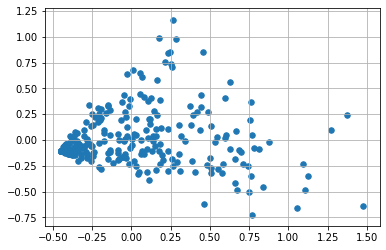

In [257]:
plt.scatter(players_df['PC1'], players_df['PC2'], s=30)
plt.grid()
plt.show()

In [258]:
pd.DataFrame(
    np.matrix.transpose(estimator.components_),
    columns=[f'PC-{i+1}' for i in range(X_pca.shape[1])],
    index=X.columns)

,PC-1,PC-2
7mPGoals,0.103966,-0.028651
7mPMissed,0.159874,-0.135935
6mCGoals,0.127241,0.093810
6mCMissed,0.160755,0.048302
WingGoals,0.150958,0.450218
WingMissed,0.130527,0.399275
BTGoals,0.160705,-0.087478
BTMissed,0.151678,-0.103124
FBGoals,0.074697,0.228254
FBMissed,0.120358,0.358909


# Clustering Expectation-Maximization

In [262]:
from sklearn.mixture import GaussianMixture

X = players_df[['PC1', 'PC2']]

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 10)

BIC = []
lowest_bic = np.infty
best_cv = 'full'
best_k = -1

for cv_type in cv_types:
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        gmm.fit(X)
        
        BIC.append(gmm.bic(X))
        if BIC[-1] < lowest_bic:
            lowest_bic = BIC[-1]
            best_cv = cv_type
            best_k = k
            
print (f"Best K: {best_k}; Best covariance type: {best_cv}")

Best K: 5; Best covariance type: full


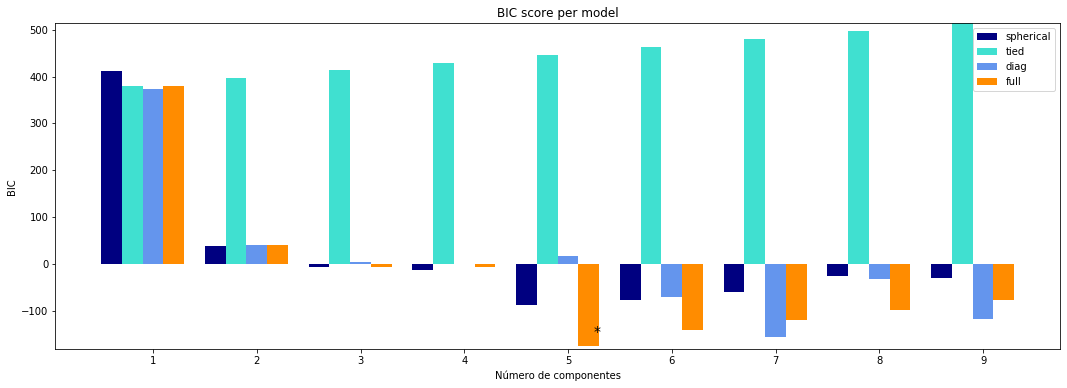

In [283]:
import itertools
import matplotlib.pyplot as plt

# Plot the BIC scores
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
bars = []
plt.figure(figsize=(18, 6))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, BIC[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(BIC) * 1.01 - .01 * max(BIC), max(BIC)])
plt.title('BIC score per model')
xpos = np.mod(np.argmin(BIC), len(n_components_range)) + .65 + .2 * np.floor(np.argmin(BIC) / len(n_components_range))
plt.text(xpos, min(BIC) * 0.97 + .03 * max(BIC), '*', fontsize=14)
plt.xlabel('Número de componentes')
plt.ylabel('BIC')
plt.legend([b[0] for b in bars], cv_types)

In [348]:
print(f"Expectation-Maximization with K={best_k} and covariance '{best_cv}'")
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
EM.fit(X)
labels =  EM.predict(X)

Expectation-Maximization with K=5 and covariance 'full'


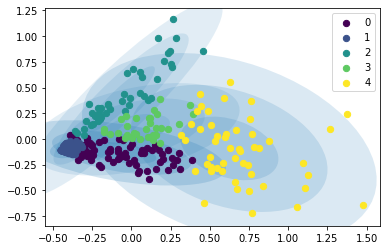

In [350]:
#plt.scatter(players_df['PC1'], players_df['PC2'], c=labels, s=30)
#plt.grid()
#plt.show()

plot_EM(EM, players_df[['PC1', 'PC2']], labels=labels)
#plot_EM(EM, players_df[['PC1', 'PC2']], labels=labels, out='../figures/Hito1_EM-final.pdf')

In [352]:
# Añadimos el cluster obtenido como un dato más
players_df['cluster'] = labels

players_df.to_csv('../models/players_EM.csv')

# Caracterización de los clústers

,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
cluster,,,,,,,,,,,,,,,,,,,,,,
0,0.478873,0.323944,0.760563,0.591549,1.056338,0.901408,1.014085,0.591549,0.338028,0.183099,0.00000,0.000000,2.633803,4.140845,0.000000,1.056338,4.126761,1.126761,0.647887,0.492958,0.915493,4.352113
1,0.013514,0.013514,0.202703,0.013514,0.135135,0.189189,0.013514,0.000000,0.081081,0.108108,0.00000,0.000000,0.040541,0.216216,0.000000,0.135135,0.662162,0.081081,0.108108,0.040541,0.040541,0.662162
2,0.744186,0.139535,0.511628,0.232558,7.604651,5.697674,0.232558,0.023256,3.162791,1.302326,0.00000,0.069767,0.023256,0.023256,0.023256,0.767442,1.511628,1.046512,2.465116,0.000000,1.627907,2.093023
3,1.312500,0.343750,3.500000,1.031250,2.781250,1.906250,0.500000,0.093750,1.187500,0.218750,0.03125,0.093750,0.562500,1.031250,0.031250,1.937500,3.468750,2.406250,2.281250,1.843750,2.656250,3.406250
4,3.220000,1.340000,3.760000,1.540000,3.240000,2.200000,3.000000,1.400000,1.520000,0.680000,0.08000,0.080000,6.860000,10.080000,0.040000,2.480000,13.740000,3.460000,3.360000,2.060000,3.140000,12.100000


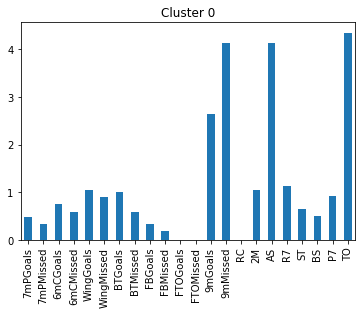

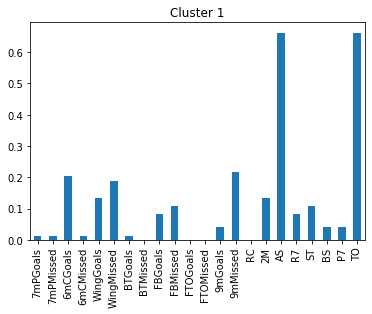

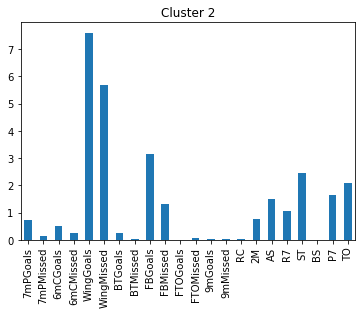

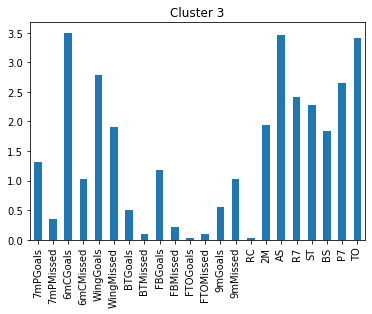

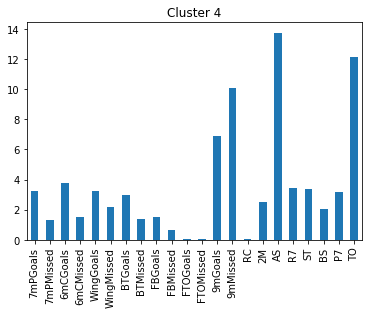

In [353]:
# Calculamos la media de todas las variables agrupando por cluster
mean_df = players_df[['cluster','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','RC','2M','AS','R7','ST','BS','P7','TO']]\
                .groupby('cluster').mean()

# Dibujamos los valores medios de las variables en cada cluster
N = len(mean_df)
for cluster_index in range(N):
    plt.figure()
    plt.title(f'Cluster {cluster_index}')
    mean_df.iloc[cluster_index].plot.bar(legend=False)
    plt.savefig(f'../figures/Hito1_EM-cluster-{cluster_index}')

mean_df

In [154]:
players_df.groupby('cluster').describe()

7mPGoals                                               7mPMissed  \
           count      mean       std  min  25%  50%  75%   max     count   
cluster                                                                    
0           54.0  2.629630  4.126748  0.0  0.0  0.5  3.0  16.0      54.0   
1           74.0  0.513514  1.867114  0.0  0.0  0.0  0.0  12.0      74.0   
2           66.0  0.015152  0.123091  0.0  0.0  0.0  0.0   1.0      66.0   
3           54.0  0.962963  3.716170  0.0  0.0  0.0  0.0  19.0      54.0   
4           18.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0      18.0   

                                                     6mCGoals            \
             mean       std  min  25%  50%  75%  max    count      mean   
cluster                                                                   
0        1.240741  1.725887  0.0  0.0  0.0  2.0  7.0     54.0  1.666667   
1        0.256757  0.993966  0.0  0.0  0.0  0.0  7.0     74.0  1.081081   
2        0.015152  0.123091  0.0  0.0  0.0  0.0  1.0     66.0  0.227273   
3        0.203704  0.594936  0.0  0.0  0.0  0.0  3.0     54.0  3.666667   
4        0.000000  0.000000  0.0  0.0  0.0  0.0  0.0     18.0  0.000000   

                                             6mCMissed                      \
              std  min  25%  50%   75%   max     count      mean       std   
cluster                                                                      
0        1.625272  0.0  1.0  1.0  2.00   7.0      54.0  1.074074  1.210829   
1        1.694122  0.0  0.0  1.0  1.00   8.0      74.0  0.391892  0.773137   
2        0.602443  0.0  0.0  0.0  0.00   3.0      66.0  0.015152  0.123091   
3        5.904907  0.0  0.0  1.0  3.75  23.0      54.0  1.296296  1.700495   
4        0.000000  0.0  0.0  0.0  0.00   0.0      18.0  0.000000  0.000000   

                                  WingGoals                                \
         min  25%  50%   75%  max     count      mean       std  min  25%   
cluster                                                                     
0        0.0  0.0  1.0  1.75  5.0      54.0  2.722222  2.374524  0.0  1.0   
1        0.0  0.0  0.0  1.00  5.0      74.0  2.567568  2.699980  0.0  0.0   
2        0.0  0.0  0.0  0.00  1.0      66.0  0.303030  0.722596  0.0  0.0   
3        0.0  0.0  1.0  2.00  8.0      54.0  5.444444  4.855134  0.0  2.0   
4        0.0  0.0  0.0  0.00  0.0      18.0  0.000000  0.000000  0.0  0.0   

                         WingMissed                                          \
         50%   75%   max      count      mean       std  min  25%  50%  75%   
cluster                                                                       
0        2.0  3.75   9.0       54.0  2.092593  1.557314  0.0  1.0  2.0  3.0   
1        2.0  5.00  11.0       74.0  1.864865  2.445708  0.0  0.0  1.0  3.0   
2        0.0  0.00   3.0       66.0  0.348485  0.712362  0.0  0.0  0.0  0.0   
3        4.0  9.75  19.0       54.0  3.851852  3.891972  0.0  1.0  2.0  6.0   
4        0.0  0.00   0.0       18.0  0.000000  0.000000  0.0  0.0  0.0  0.0   

              BTGoals                                               BTMissed  \
          max   count      mean       std  min  25%  50%  75%   max    count   
cluster                                                                        
0         9.0    54.0  3.037037  2.814806  0.0  1.0  2.0  5.0  12.0     54.0   
1        10.0    74.0  0.337838  0.625421  0.0  0.0  0.0  1.0   3.0     74.0   
2         3.0    66.0  0.030303  0.172733  0.0  0.0  0.0  0.0   1.0     66.0   
3        15.0    54.0  0.592593  1.019036  0.0  0.0  0.0  1.0   5.0     54.0   
4         0.0    18.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0     18.0   

                                                     FBGoals            \
             mean       std  min  25%  50%  75%  max   count      mean   
cluster                                                                  
0        1.425926  1.573385  0.0  0.0  1.0  2.0  6.0    54.0